# Load and clean the dataset

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Descriptors,AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
import rdkit.Chem.Descriptors3D
from morfeus import xtb, read_xyz
import os

In [2]:
file_path = '20240621_Dataset_Raw_Exp.xlsx'

solubility_df = pd.read_excel(file_path, sheet_name='Solubility', engine='openpyxl')
solvents_df = pd.read_excel(file_path, sheet_name='Solvents', engine='openpyxl')
drugs_df = pd.read_excel(file_path, sheet_name='Drugs', engine='openpyxl')


In [3]:
solubility_df.shape

(28098, 9)

In [4]:
lab = solubility_df[solubility_df['DOI'] == 'Lab']
lab.shape

(24, 9)

In [5]:
literature = solubility_df[solubility_df['DOI'] != 'Lab']
literature.shape

(28074, 9)

In [6]:
literature

,Web of Science Index,Drug,Solvent_1,Solvent_1_weight_fraction,Solvent_1_mol_fraction,Solvent_2,Temperature (K),Solubility (mol/mol),DOI
0,36,Guanidine hydrochloride,Dimethylformamide,0.1001,NaN,1-Propanol,278.15,0.069400,doi.org/10.1016/j.molliq.2023.122902
1,36,Guanidine hydrochloride,Dimethylformamide,0.1001,NaN,1-Propanol,283.15,0.077050,doi.org/10.1016/j.molliq.2023.122902
2,36,Guanidine hydrochloride,Dimethylformamide,0.1001,NaN,1-Propanol,288.15,0.084960,doi.org/10.1016/j.molliq.2023.122902
3,36,Guanidine hydrochloride,Dimethylformamide,0.1001,NaN,1-Propanol,293.15,0.090850,doi.org/10.1016/j.molliq.2023.122902
4,36,Guanidine hydrochloride,Dimethylformamide,0.1001,NaN,1-Propanol,298.15,0.097740,doi.org/10.1016/j.molliq.2023.122902
...,...,...,...,...,...,...,...,...,...
28069,1332,Vinpocetine,Ethanol,NaN,0.9,Water,303.15,0.001184,DOI: 10.1021/acs.jced.8b00663
28070,1332,Vinpocetine,Ethanol,NaN,0.9,Water,308.15,0.001538,DOI: 10.1021/acs.jced.8b00663
28071,1332,Vinpocetine,Ethanol,NaN,0.9,Water,313.15,0.001874,DOI: 10.1021/acs.jced.8b00663
28072,1332,Vinpocetine,Ethanol,NaN,0.9,Water,318.15,0.002436,DOI: 10.1021/acs.jced.8b00663


In [7]:
def duplicate_removal(df):
    
    df['Mono solvent'] = 'No'

    df.loc[(df['Solvent_1_weight_fraction'] == 1) | (df['Solvent_1_mol_fraction'] == 1), 'Mono solvent'] = df['Solvent_1']
    df.loc[(df['Solvent_1_weight_fraction'] == 0) | (df['Solvent_1_mol_fraction'] == 0), 'Mono solvent'] = df['Solvent_2']

    df_no_duplicates = df[df['Mono solvent'] != 'No'].drop_duplicates(subset=['Drug', 'Mono solvent', 'Temperature (K)'])

    result_df = pd.concat([df[df['Mono solvent'] == 'No'], df_no_duplicates], ignore_index=True)
    
    result_df = result_df.drop(['Mono solvent'], axis = 1)

    return result_df

In [8]:
literature = duplicate_removal(literature)
literature.shape

/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_96668/1118413826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mono solvent'] = 'No'


(26706, 9)

In [9]:
literature['Solvent_1_Fraction'] = literature['Solvent_1_weight_fraction'].combine_first(literature['Solvent_1_mol_fraction'])
literature['Solvent_2_Fraction'] = 1 - literature['Solvent_1_Fraction']

In [10]:
literature

,Web of Science Index,Drug,Solvent_1,Solvent_1_weight_fraction,Solvent_1_mol_fraction,Solvent_2,Temperature (K),Solubility (mol/mol),DOI,Solvent_1_Fraction,Solvent_2_Fraction
0,36,Guanidine hydrochloride,Dimethylformamide,0.1001,NaN,1-Propanol,278.15,0.069400,doi.org/10.1016/j.molliq.2023.122902,0.1001,0.8999
1,36,Guanidine hydrochloride,Dimethylformamide,0.1001,NaN,1-Propanol,283.15,0.077050,doi.org/10.1016/j.molliq.2023.122902,0.1001,0.8999
2,36,Guanidine hydrochloride,Dimethylformamide,0.1001,NaN,1-Propanol,288.15,0.084960,doi.org/10.1016/j.molliq.2023.122902,0.1001,0.8999
3,36,Guanidine hydrochloride,Dimethylformamide,0.1001,NaN,1-Propanol,293.15,0.090850,doi.org/10.1016/j.molliq.2023.122902,0.1001,0.8999
4,36,Guanidine hydrochloride,Dimethylformamide,0.1001,NaN,1-Propanol,298.15,0.097740,doi.org/10.1016/j.molliq.2023.122902,0.1001,0.8999
...,...,...,...,...,...,...,...,...,...,...,...
26701,1331,Carbendazim,1-Propanol,1.0000,NaN,Water,298.15,0.000018,doi.org/10.1016/j.jct.2018.08.001,1.0000,0.0000
26702,1331,Carbendazim,1-Propanol,1.0000,NaN,Water,303.15,0.000027,doi.org/10.1016/j.jct.2018.08.001,1.0000,0.0000
26703,1331,Carbendazim,1-Propanol,1.0000,NaN,Water,308.15,0.000040,doi.org/10.1016/j.jct.2018.08.001,1.0000,0.0000
26704,1331,Carbendazim,1-Propanol,1.0000,NaN,Water,313.15,0.000058,doi.org/10.1016/j.jct.2018.08.001,1.0000,0.0000


In [11]:
def check_and_swap(group):
    correlation_1 = group['Solvent_1_Fraction'].corr(group['Solubility (mol/mol)'])
    correlation_2 = group['Solvent_2_Fraction'].corr(group['Solubility (mol/mol)'])

    if correlation_1 < correlation_2:

        temp_solvent = group['Solvent_1'].copy()
        group['Solvent_1'] = group['Solvent_2']
        group['Solvent_2'] = temp_solvent


        group['Solvent_1_Fraction'] = 1 - group['Solvent_1_Fraction']
        

        if 'Solvent_1_weight_fraction' in group and group['Solvent_1_weight_fraction'].notna().all():
            group['Solvent_1_weight_fraction'] = 1 - group['Solvent_1_weight_fraction']

        if 'Solvent_1_mol_fraction' in group and group['Solvent_1_mol_fraction'].notna().all():
            group['Solvent_1_mol_fraction'] = 1 - group['Solvent_1_mol_fraction']

    return group


literature = literature.groupby(['Drug', 'Solvent_1', 'Solvent_2', 'Temperature (K)']).apply(check_and_swap).reset_index(drop=True)


/Users/zeqing/opt/anaconda3/envs/morfeus/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/zeqing/opt/anaconda3/envs/morfeus/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [12]:
literature

,Web of Science Index,Drug,Solvent_1,Solvent_1_weight_fraction,Solvent_1_mol_fraction,Solvent_2,Temperature (K),Solubility (mol/mol),DOI,Solvent_1_Fraction,Solvent_2_Fraction
0,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,NaN,0.9406,4-Methyl-2-pentanone,293.15,0.168100,doi.org/10.1021/acs.jced.2c00228,0.9406,0.0594
1,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,NaN,0.8755,4-Methyl-2-pentanone,293.15,0.158100,doi.org/10.1021/acs.jced.2c00228,0.8755,0.1245
2,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,NaN,0.8040,4-Methyl-2-pentanone,293.15,0.144200,doi.org/10.1021/acs.jced.2c00228,0.8040,0.1960
3,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,NaN,0.7251,4-Methyl-2-pentanone,293.15,0.125800,doi.org/10.1021/acs.jced.2c00228,0.7251,0.2749
4,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,NaN,0.6375,4-Methyl-2-pentanone,293.15,0.106600,doi.org/10.1021/acs.jced.2c00228,0.6375,0.3625
...,...,...,...,...,...,...,...,...,...,...,...
26701,75,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,NaN,0.5000,Water,368.15,0.062300,doi.org/10.1016/j.jct.2023.107097,0.5000,0.5000
26702,75,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,NaN,0.3750,Water,368.15,0.022000,doi.org/10.1016/j.jct.2023.107097,0.3750,0.3750
26703,75,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,NaN,0.2500,Water,368.15,0.004450,doi.org/10.1016/j.jct.2023.107097,0.2500,0.2500
26704,75,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,NaN,0.1250,Water,368.15,0.000976,doi.org/10.1016/j.jct.2023.107097,0.1250,0.1250


In [13]:
literature = literature.drop(['Solvent_1_Fraction', 'Solvent_2_Fraction'], axis = 1)

In [14]:
literature

,Web of Science Index,Drug,Solvent_1,Solvent_1_weight_fraction,Solvent_1_mol_fraction,Solvent_2,Temperature (K),Solubility (mol/mol),DOI
0,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,NaN,0.9406,4-Methyl-2-pentanone,293.15,0.168100,doi.org/10.1021/acs.jced.2c00228
1,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,NaN,0.8755,4-Methyl-2-pentanone,293.15,0.158100,doi.org/10.1021/acs.jced.2c00228
2,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,NaN,0.8040,4-Methyl-2-pentanone,293.15,0.144200,doi.org/10.1021/acs.jced.2c00228
3,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,NaN,0.7251,4-Methyl-2-pentanone,293.15,0.125800,doi.org/10.1021/acs.jced.2c00228
4,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,NaN,0.6375,4-Methyl-2-pentanone,293.15,0.106600,doi.org/10.1021/acs.jced.2c00228
...,...,...,...,...,...,...,...,...,...
26701,75,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,NaN,0.5000,Water,368.15,0.062300,doi.org/10.1016/j.jct.2023.107097
26702,75,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,NaN,0.3750,Water,368.15,0.022000,doi.org/10.1016/j.jct.2023.107097
26703,75,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,NaN,0.2500,Water,368.15,0.004450,doi.org/10.1016/j.jct.2023.107097
26704,75,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,NaN,0.1250,Water,368.15,0.000976,doi.org/10.1016/j.jct.2023.107097


In [15]:
duplicates_mask = literature.duplicated(subset=['Drug', 'Solvent_1', 'Solvent_1_weight_fraction', 'Solvent_1_mol_fraction', 'Solvent_2', 'Temperature (K)'], keep=False)

df_duplicates = literature[duplicates_mask]

df_duplicates = df_duplicates.reset_index(drop=True)

df_duplicates_sorted = df_duplicates.sort_values(by=['Drug', 'Solvent_1', 'Solvent_1_weight_fraction', 'Solvent_1_mol_fraction', 'Solvent_2', 'Temperature (K)']).reset_index(drop=True)

df_duplicates_sorted.shape[0]



0

# Generate features

## Tautomers, charge state, and diastereomers

In [16]:
def find_diastereomers(df,Compound):
    possible_diastereomers = []
    
    for index, row in df.iterrows():
        smiles = row['SMILES']
        #smiles = row['SMILES']
        drug_name = row[Compound]
        

        mol = Chem.MolFromSmiles(smiles)
        
        if mol:
            chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
            

            if len(chiral_centers) > 1:
                possible_diastereomers.append(drug_name)
    
    return possible_diastereomers

In [17]:
possible_diastereomers = find_diastereomers(drugs_df, 'Drug')
print("possible_diastereomers:")
for drug in possible_diastereomers:
    print(drug)

possible_diastereomers:
Glucosamine hydrochloride
Itraconazole
5-Azacytidine
Florfenicol
Sofosbuvir
Posaconazole
Gestodene
Labetalol hydrochloride
Oleanolic acid
Ursolic acid
Trans-4-Hydroxy‐L‐proline
Pidotimod
D(−)-Salicin
Etonogestrel
Ketoconazole
D‐Ribose
Lanosterol
Capecitabine
Griseofulvin
Azlocillin
Rivastigmine tartrate
Artesunate
Vinpocetine
Hydrocortisone


In [18]:
possible_diastereomers = find_diastereomers(solvents_df, 'Solvent')
print("possible_diastereomers:")
for solvent in possible_diastereomers:
    print(solvent)

possible_diastereomers:


In [19]:
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()
uncharger = rdMolStandardize.Uncharger()

def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = tautomer_enumerator.Canonicalize(mol)
    mol = uncharger.uncharge(mol)
    return Chem.MolToSmiles(mol)

In [20]:
drugs_df['standardized_SMILES'] = drugs_df['SMILES'].apply(standardize_smiles)

[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Can't kekulize mol.  Unkekulized

In [21]:
solvents_df['standardized_SMILES'] = solvents_df['SMILES'].apply(standardize_smiles)

[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Running Uncharger
[10:15:53] Run

## XTB_features

In [325]:
def calculate_xtb_features(smile, max_tries=500):
    print('')
    print(smile)
    for attempt in range(max_tries):
        try:

            mol = Chem.MolFromSmiles(smile)
            mol_3d = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol_3d)

            AllChem.UFFOptimizeMolecule(mol_3d, maxIters=500000)
            xyz_file = "molecule.xyz"

            with open(xyz_file, "w") as f:
                f.write(Chem.MolToXYZBlock(mol_3d))
        
            atoms, coordinates = read_xyz(xyz_file)

            xtb_instance = xtb.XTB(atoms, coordinates)
            
            xtb_ea = xtb_instance.get_ea()
            xtb_global_descriptor = xtb_instance.get_global_descriptor('electrophilicity')
            xtb_homo = xtb_instance.get_homo()
            xtb_ip = xtb_instance.get_ip()
            xtb_lumo = xtb_instance.get_lumo()
            
            return [xtb_ea, xtb_global_descriptor, xtb_homo, xtb_ip, xtb_lumo]
        
        except Exception as e:
            if attempt%5==0:
                print(f"Attempt {attempt + 1} failed")
            if attempt == max_tries - 1:
                raise Exception(f"Failed to calculate XTB features after {max_tries} attempts.")

In [326]:
xtb_drug_features_list = []

for smile in drugs_df['standardized_SMILES']:
    xtb_drug_features = calculate_xtb_features(smile)
    xtb_drug_features_list.append(xtb_drug_features)
    xtb_drug_features_df = pd.DataFrame(xtb_drug_features_list, columns=['xtb_ea', 'xtb_global_descriptor', 'xtb_homo', 'xtb_ip', 'xtb_lumo'])

xtb_drug_features_df.to_excel("xtb_drug_features.xlsx")



Cl.N=C(N)N
Attempt 1 failed

Cl.NC(C=O)C(O)C(O)C(O)CO
Attempt 1 failed

Nc1cncc(Cl)n1

Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1.O=[N+]([O-])[O-]

O=C1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1

CCC(C)n1ncn(-c2ccc(N3CCN(c4ccc(OC[C@H]5CO[C@](Cn6cncn6)(c6ccc(Cl)cc6Cl)O5)cc4)CC3)cc2)c1=O

O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])CN([N+](=O)[O-])C1

NC(=O)Nc1[nH]c(=O)[nH]c1O

NC(Cc1c[nH]c2ccccc12)C(=O)O

Cc1ccc2cc(Br)ccc2n1

CCCCN1CCCCC1C(=O)Nc1c(C)cccc1C.Cl.O

O=C(O)c1ccc(C(=O)O)o1

CC(=O)Nc1ccc(O)cc1

Nc1ccc(O)c(C(=O)O)c1

Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1

Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1

Nc1cccc2ccncc12

CN1CCC(N(Cc2cccs2)c2ccccc2)CC1

CCOc1ccc(NC(C)=O)cc1

NCCS(=O)(=O)O

O=C(O)c1cc([N+](=O)[O-])ccc1O

CC(=O)Oc1cccc2c1C(=O)c1c(OC(C)=O)cc(C(=O)O)cc1C2=O

CCOC(=O)OC1=C(c2cc(C)ccc2C)C(=O)N[C@]12CC[C@@H](OC)CC2

CS(=O)(=O)c1ccc([C@@H](O)[C@@H](CF)NC(=O)C(Cl)Cl)cc1

Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S(N)(=O)=O

O=c1[nH]cc(F)c(=O)[nH]1

NO.O=S(=O)(O)

In [327]:
xtb_solvent_features_list = []

for smile in solvents_df['standardized_SMILES']:
    xtb_solvent_features = calculate_xtb_features(smile)
    xtb_solvent_features_list.append(xtb_solvent_features)
    xtb_solvent_features_df = pd.DataFrame(xtb_solvent_features_list, columns=['xtb_ea', 'xtb_global_descriptor', 'xtb_homo', 'xtb_ip', 'xtb_lumo'])

xtb_solvent_features_df.to_excel("xtb_solvent_features.xlsx")



CN(C)C=O

COCCO

CO

CN1CCCC1=O

O

CCO

CCCO

CC(O)CO

CC(C)=O

CC(C)O

CCC(C)=O

ClCCl

ClC(Cl)Cl

OCCO

CS(C)=O

O=CN1CCOCC1

CC#N

CCOC(C)=O

CC(=O)N(C)C

CCCCO

C1CCOC1

CC(C)CO

C1COCCO1

CC1=CC(=O)CC(C)(C)C1

ClCCCl

CCOCCO

CCCOC(C)=O

OCc1ccccc1

O=C(OCc1ccccc1)c1ccccc1

CC(=O)OCc1ccccc1

CCCCOC(C)=O

COC(C)=O

CC(=O)CC(C)C

O=CO

CC(=O)O

COCCOC

COCCOCCOC

O=C1CCCC1

CCCCCC

CCCOCCO

CCCCOCCO

Cc1ccccc1

CCCCCCC

C1CCCCC1


## Other features

In [22]:
def generate_feats(df, xtb_features):
    example = Chem.MolFromSmiles('C')
    example = Chem.AddHs(example)
    AllChem.EmbedMolecule(example)
    threeD_columns = [col for col in rdkit.Chem.Descriptors3D.CalcMolDescriptors3D(example)]
    
    maccs_list = []
    descriptors_list = []
    extra_list = []
    descriptors3d_list = []

    descriptor_names = [desc[0] for desc in Descriptors._descList]
    descriptor_functions = [desc[1] for desc in Descriptors._descList]

    for smile in df['standardized_SMILES']:

        mol = Chem.MolFromSmiles(smile)
        
        mol_3d = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol_3d)
        
        fingerprint = MACCSkeys.GenMACCSKeys(mol)
        maccs_list.append(list(fingerprint)[1:])
        
        descriptor_values = [func(mol) for func in descriptor_functions]
        descriptors_list.append(descriptor_values)
        
        volume = AllChem.ComputeMolVolume(mol_3d)
        AllChem.ComputeGasteigerCharges(mol_3d)
        dipole = sum(float(mol_3d.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) * mol_3d.GetConformer().GetAtomPosition(i).x for i in range(mol_3d.GetNumAtoms()))
        extra_desc = [volume, dipole]
        extra_list.append(extra_desc)

        descriptors3d_values = rdkit.Chem.Descriptors3D.CalcMolDescriptors3D(mol_3d)
        descriptors3d_list.append(descriptors3d_values)


    maccs_df = pd.DataFrame(maccs_list, columns=[f'Maccs_{i}' for i in range(1, 167)])
    descriptors_df = pd.DataFrame(descriptors_list, columns=[name for name in descriptor_names])
    extra_desc_df = pd.DataFrame(extra_list, columns=['Volume', 'Dipole Moment'])

    descriptors3d_df = pd.DataFrame(descriptors3d_list, columns=threeD_columns)


    combined_df = pd.concat([df, maccs_df, descriptors_df, extra_desc_df, descriptors3d_df,xtb_features ], axis=1)

    return combined_df


In [23]:
xtb_drug_features_df = pd.read_excel("xtb_drug_features.xlsx")

drug_feats = generate_feats(drugs_df, xtb_drug_features_df)


[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:03] DEPRECATION WARNING: please use MorganGenerator
[10:16:04] DEPRECATION WARNING: please use MorganGenerator
[10:16:04] DEPRECATION WARNING: please use MorganGenerat

In [24]:
xtb_solvent_features_df = pd.read_excel("xtb_solvent_features.xlsx")
solvent_feats = generate_feats(solvents_df, xtb_solvent_features_df)
solvent_feats

[10:16:22] DEPRECATION WARNING: please use MorganGenerator
[10:16:22] DEPRECATION WARNING: please use MorganGenerator
[10:16:22] DEPRECATION WARNING: please use MorganGenerator
[10:16:22] DEPRECATION WARNING: please use MorganGenerator
[10:16:22] DEPRECATION WARNING: please use MorganGenerator
[10:16:22] DEPRECATION WARNING: please use MorganGenerator
[10:16:23] DEPRECATION WARNING: please use MorganGenerator
[10:16:23] DEPRECATION WARNING: please use MorganGenerator
[10:16:23] DEPRECATION WARNING: please use MorganGenerator
[10:16:23] DEPRECATION WARNING: please use MorganGenerator
[10:16:23] DEPRECATION WARNING: please use MorganGenerator
[10:16:23] DEPRECATION WARNING: please use MorganGenerator
[10:16:23] DEPRECATION WARNING: please use MorganGenerator
[10:16:23] DEPRECATION WARNING: please use MorganGenerator
[10:16:23] DEPRECATION WARNING: please use MorganGenerator
[10:16:23] DEPRECATION WARNING: please use MorganGenerator
[10:16:23] DEPRECATION WARNING: please use MorganGenerat

,Solvent,CAS,isomeric_SMILES,SMILES,CAS_MP (C),SCBT_MP (C),Sigma_MP (C),Fisher_MP (C),Wiki_MP (C),Collected_Melting_temp (C),...,Eccentricity,Asphericity,SpherocityIndex,PBF,Unnamed: 0,xtb_ea,xtb_global_descriptor,xtb_homo,xtb_ip,xtb_lumo
0,Dimethylformamide,68-12-2,N(C=O)(C)C,O=CN(C)C,-61.00,-61.0,-61.0,NaN,NaN,-61.000000,...,0.944620,0.327877,0.234367,0.347472,0,2.297127,2.823379,-0.386780,13.872144,-0.236220
1,2-Methoxyethanol,109-86-4,C(CO)OC,OCCOC,-85.10,-85.0,-85.0,NaN,NaN,-85.033333,...,0.985402,0.575047,0.298641,0.486874,1,-3.641369,0.740938,-0.391614,13.812911,0.024385
2,Methanol,67-56-1,CO,OC,-97.80,NaN,-98.0,-98.0,NaN,-97.933333,...,0.980907,0.534514,0.567606,0.387676,2,-5.319015,0.613899,-0.415041,15.408440,0.053291
3,N-methyl-2-pyrrolidone,872-50-4,O=C1N(C)CCC1,O=C1N(C)CCC1,-25.00,-24.0,-24.0,NaN,NaN,-24.333333,...,0.864150,0.194044,0.342021,0.522085,3,2.097933,2.659911,-0.380499,13.432207,-0.216879
4,Water,7732-18-5,O,O,0.00,NaN,0.0,0.0,NaN,0.000000,...,0.942922,0.333653,0.000000,0.000000,4,-5.534605,0.844549,-0.445794,18.197206,0.040718
5,Ethanol,64-17-5,C(C)O,OCC,-114.10,NaN,-114.0,NaN,-114.14,-114.080000,...,0.969099,0.434936,0.491450,0.496665,5,-4.753128,0.658164,-0.412222,14.934580,0.048279
6,1-Propanol,71-23-8,C(CO)C,OCCC,-127.00,-127.0,-127.0,NaN,NaN,-127.000000,...,0.934327,0.279213,0.583973,0.629009,6,-4.360599,0.668754,-0.407494,14.371446,0.044259
7,Propylene glycol,57-55-6,C(CO)(C)O,OCC(O)C,-59.00,-59.0,-60.0,NaN,NaN,-59.333333,...,0.935554,0.287120,0.514397,0.532707,7,-3.392062,0.843896,-0.408113,14.330405,0.016209
8,Acetone,67-64-1,C(C)(C)=O,O=C(C)C,-94.80,NaN,-94.0,-95.0,NaN,-94.600000,...,0.882852,0.216150,0.323876,0.404167,8,2.726801,3.160145,-0.397265,14.594685,-0.252488
9,2-Propanol,67-63-0,C(C)(C)O,OC(C)C,-88.50,-89.5,-89.5,NaN,NaN,-89.166667,...,0.817005,0.147344,0.544698,0.567858,9,-4.097090,0.716772,-0.405933,14.394328,0.035587


## Add features to the dataset

In [28]:
def enhance_solubility_data(solubility_df, drugs_df, solvents_df, drug_features, solvent_features):

    drug_col_rename_map = {feature: f"Drug_{feature}" for feature in drug_features}
    selected_drug_features = drugs_df[drug_features + ['Drug']]
    renamed_drug_features = selected_drug_features.rename(columns=drug_col_rename_map)
    enhanced_df = solubility_df.merge(renamed_drug_features, on='Drug', how='left')

    solvent_1_col_rename_map = {feature: f"Solvent_1_{feature}" for feature in solvent_features}
    solvent_1_col_rename_map['Solvent'] = 'Solvent_1'
    selected_solvent_1_features = solvents_df[solvent_features + ['Solvent']].rename(columns=solvent_1_col_rename_map)
    enhanced_df = enhanced_df.merge(selected_solvent_1_features, left_on='Solvent_1', right_on='Solvent_1', how='left')

    solvent_2_col_rename_map = {feature: f"Solvent_2_{feature}" for feature in solvent_features}
    solvent_2_col_rename_map['Solvent'] = 'Solvent_2'
    selected_solvent_2_features = solvents_df[solvent_features + ['Solvent']].rename(columns=solvent_2_col_rename_map)
    enhanced_df = enhanced_df.merge(selected_solvent_2_features, left_on='Solvent_2', right_on='Solvent_2', how='left')

    return enhanced_df


# More descriptors

In [25]:
maccs_feats = [f'Maccs_{i}' for i in range(1, 167)]
rdkit_feats = [desc[0] for desc in Descriptors._descList]
xtb_feats = ['xtb_ea', 'xtb_global_descriptor', 'xtb_homo', 'xtb_ip', 'xtb_lumo']
extra_feats = ['Volume', 'Dipole Moment']

example = Chem.MolFromSmiles('C')
example = Chem.AddHs(example)
AllChem.EmbedMolecule(example)
threeD_feats = [col for col in rdkit.Chem.Descriptors3D.CalcMolDescriptors3D(example)]




calculated_feats = maccs_feats + rdkit_feats + xtb_feats + extra_feats + ['Dielectric_constant'] + threeD_feats 
calculated_feats_df = pd.DataFrame()
calculated_feats_df['Features'] = calculated_feats
calculated_feats_df.to_excel('Feature_list.xlsx')

In [26]:
maccs_feats = [f'Maccs_{i}' for i in range(1, 167)]
rdkit_feats = [desc[0] for desc in Descriptors._descList]
xtb_feats = ['xtb_ea', 'xtb_global_descriptor', 'xtb_homo', 'xtb_ip', 'xtb_lumo']
extra_feats = ['Volume', 'Dipole Moment']

example = Chem.MolFromSmiles('C')
example = Chem.AddHs(example)
AllChem.EmbedMolecule(example)
threeD_feats = [col for col in rdkit.Chem.Descriptors3D.CalcMolDescriptors3D(example)]




calculated_feats = maccs_feats + rdkit_feats + xtb_feats + extra_feats + threeD_feats


drug_feats_to_extract = ['Collected_Melting_temp (K)', 'Predicted_Melting_temp (K)', 'Drugs@FDA', 'SMILES'] + calculated_feats 
solvent_feats_to_extract = ['Collected_Melting_temp (K)', 'Dielectric_constant']  + calculated_feats 

In [29]:
enhanced_literature = enhance_solubility_data(literature, drug_feats, solvent_feats, drug_feats_to_extract, solvent_feats_to_extract)
enhanced_literature.shape



(26706, 1199)

In [30]:
enhanced_lab = enhance_solubility_data(lab, drug_feats, solvent_feats, drug_feats_to_extract, solvent_feats_to_extract)
enhanced_lab.shape



(24, 1199)

# Unit conversion

In [31]:
def calculate_fractions(df):
    for index, row in df.iterrows():

        molecular_weight_1 = row['Solvent_1_ExactMolWt']
        molecular_weight_2 = row['Solvent_2_ExactMolWt']

        if pd.isna(row['Solvent_1_mol_fraction']) and not pd.isna(row['Solvent_1_weight_fraction']):
            weight_fraction_1 = float(row['Solvent_1_weight_fraction'])
            weight_fraction_2 = 1 - weight_fraction_1
            mole_fraction_1 = (weight_fraction_1 / molecular_weight_1) / ((weight_fraction_1 / molecular_weight_1) + (weight_fraction_2 / molecular_weight_2))
            df.at[index, 'Solvent_1_mol_fraction'] = mole_fraction_1

        elif not pd.isna(row['Solvent_1_mol_fraction']) and pd.isna(row['Solvent_1_weight_fraction']):
            mole_fraction_1 = float(row['Solvent_1_mol_fraction'])
            mole_fraction_2 = 1 - mole_fraction_1
            weight_fraction_1 = (mole_fraction_1 * molecular_weight_1) / ((mole_fraction_1 * molecular_weight_1) + (mole_fraction_2 * molecular_weight_2))
            df.at[index, 'Solvent_1_weight_fraction'] = weight_fraction_1
            
    return df


enhanced_literature = calculate_fractions(enhanced_literature)
enhanced_lab = calculate_fractions(enhanced_lab)



In [32]:
def calculate_logs(df_updated):
    
    total_moles = 1

    df_updated['mol0'] = total_moles * df_updated['Solubility (mol/mol)']
    df_updated['mol1'] = (total_moles - df_updated['mol0']) * df_updated['Solvent_1_mol_fraction']
    df_updated['mol2'] = (total_moles - df_updated['mol0']) * (1 - df_updated['Solvent_1_mol_fraction'])
    df_updated['total_mol'] = df_updated['mol0'] + df_updated['mol1'] + df_updated['mol2']
    print(df_updated[['total_mol']].describe())

    df_updated['mass0'] = df_updated['mol0'] * df_updated['Drug_ExactMolWt']
    df_updated['mass1'] = df_updated['mol1'] * df_updated['Solvent_1_ExactMolWt']
    df_updated['mass2'] = df_updated['mol2'] * df_updated['Solvent_2_ExactMolWt']
    df_updated['total_mass'] = df_updated['mass0'] + df_updated['mass1'] + df_updated['mass2']

    df_updated['Solubility (g/g)'] = df_updated['mass0'] / df_updated['total_mass']
    df_updated['Solubility (g/100g)'] = df_updated['Solubility (g/g)'] * 100
    df_updated['LogS'] = np.log10(df_updated['Solubility (g/100g)'])

    df_updated = df_updated.drop(['mol0', 'mol1', 'mol2', 'mass0','mass1','mass2','total_mass','total_mol','Solubility (g/g)'], axis = 1)
    
    return df_updated

In [33]:
updated_literature = calculate_logs(enhanced_literature)


          total_mol
count  2.670600e+04
mean   1.000000e+00
std    3.807570e-17
min    1.000000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    1.000000e+00
max    1.000000e+00


In [34]:
updated_lab = calculate_logs(enhanced_lab)


          total_mol
count  2.400000e+01
mean   1.000000e+00
std    4.009654e-17
min    1.000000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    1.000000e+00
max    1.000000e+00


In [35]:
columns_with_missing_values = updated_lab.columns[updated_lab.isna().any()] + updated_lab.columns[updated_lab.isna().any()]
len(columns_with_missing_values)


0

# Train/test split

In [36]:
quantiles = updated_literature['LogS'].quantile([0.00, 0.25, 0.50, 0.75, 1.00])

def determine_class(x):
    if x <= quantiles[0.25]:
        return f"[{round(quantiles[0.00],2)}, {round(quantiles[0.25],2)}]"
    elif x <= quantiles[0.5]:
        return f"({round(quantiles[0.25],2)}, {round(quantiles[0.5],2)}]"
    elif x <= quantiles[0.75]:
        return f"({round(quantiles[0.5],2)}, {round(quantiles[0.75],2)}]"
    else:
        return f"({round(quantiles[0.75],2)}, {round(quantiles[1.0],2)}]"


updated_literature['Class'] = updated_literature['LogS'].apply(determine_class)

updated_lab['Class'] = None

print(round(quantiles[0.00],2),round(quantiles[0.25],2),round(quantiles[0.5],2),round(quantiles[0.75],2), round(quantiles[1.00],2),)

-5.48 -0.43 0.36 1.0 1.99


In [37]:
def drug_solvent_system(row):

    sorted_solvents = sorted([row['Solvent_1'], row['Solvent_2']])

    return f"{row['Drug']}-{sorted_solvents[0]}/{sorted_solvents[1]}"

updated_literature['Drug-solvent system'] = updated_literature.apply(drug_solvent_system, axis=1)
updated_lab['Drug-solvent system'] = updated_lab.apply(drug_solvent_system, axis=1)

In [38]:
def solvent_system(row):

    sorted_solvents = sorted([row['Solvent_1'], row['Solvent_2']])

    return f"{sorted_solvents[0]}/{sorted_solvents[1]}"

updated_literature['Solvent system'] = updated_literature.apply(solvent_system, axis=1)
updated_lab['Solvent system'] = updated_lab.apply(solvent_system, axis=1)

In [39]:
updated_literature.reset_index(drop=True, inplace=True)

gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=19680611)
#gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_idx, test_idx in gss.split(updated_literature, groups=updated_literature['Drug-solvent system']):
    updated_literature.loc[train_idx, 'Type'] = 'Train'
    updated_literature.loc[test_idx, 'Type'] = 'Test'

    
train_subset = updated_literature[updated_literature['Type'] == 'Train']
test_subset = updated_literature[updated_literature['Type'] == 'Test']
updated_lab['Type'] = 'Lab'

In [40]:
train_subset.shape

(19896, 1205)

In [41]:
test_subset.shape

(6810, 1205)

In [42]:
updated_lab.shape

(24, 1205)

In [43]:
overlapping_groups = set(train_subset['Drug-solvent system']).intersection(set(test_subset['Drug-solvent system']))
len(overlapping_groups)

0

In [44]:
def analyze_solute_data(df):
    
    unique_solute = df['Drug'].nunique()
    
    
    unique_solvents = pd.concat([df['Solvent_1'], df['Solvent_2']]).nunique()

    
    
    unique_solvent_systems = df['Solvent system'].nunique()
    
    
    
    unique_drug_solvent_systems = df['Drug-solvent system'].nunique()

    
    print(f"Number of unique solute: {unique_solute}")
    print(f"Number of unique solvents: {unique_solvents}")
    print(f"Number of unique solvent systems: {unique_solvent_systems}")
    print(f"Number of unique drug-solvent systems: {unique_drug_solvent_systems}")
    print(f"Number of data entries: {df.shape[0]}")



In [45]:
analyze_solute_data(updated_literature)

Number of unique solute: 123
Number of unique solvents: 44
Number of unique solvent systems: 110
Number of unique drug-solvent systems: 373
Number of data entries: 26706


In [46]:
analyze_solute_data(train_subset)

Number of unique solute: 117
Number of unique solvents: 41
Number of unique solvent systems: 95
Number of unique drug-solvent systems: 279
Number of data entries: 19896


In [47]:
analyze_solute_data(test_subset)

Number of unique solute: 68
Number of unique solvents: 27
Number of unique solvent systems: 43
Number of unique drug-solvent systems: 94
Number of data entries: 6810


In [48]:
analyze_solute_data(updated_lab)

Number of unique solute: 4
Number of unique solvents: 2
Number of unique solvent systems: 1
Number of unique drug-solvent systems: 4
Number of data entries: 24


# Plot

In [49]:
def plot_stacked_bar_chart(ann, ax, df_no_outliers, fontsize = 10):
    
    df = df_no_outliers.copy()

    
    solubility_order = ['[-5.48, -0.43]', '(-0.43, 0.36]', '(0.36, 1.0]', '(1.0, 1.99]']
      

    
    quantile_edges = df['Temperature (K)'].quantile([0, 0.25, 0.5, 0.75, 1]).values
    quantile_labels = [f"{quantile_edges[i]:.2f}K to {quantile_edges[i+1]:.2f}K" for i in range(len(quantile_edges)-1)]

    
    df['Temp Quantile Bin'] = pd.cut(df['Temperature (K)'], bins=quantile_edges, labels=quantile_labels, include_lowest=True)

    
    grouped_by_solubility_and_quantile = df.groupby(['Class', 'Temp Quantile Bin']).size().unstack()
    grouped_quantile_ordered = grouped_by_solubility_and_quantile.reindex(solubility_order)

    
    lightest = "#D3D4D9"
    light = "#A8A9B2"
    medium = "#515265"
    dark = "#3D3E4C"
    
    lightest = "gainsboro"
    light = "darkgrey"
    medium = "gray"
    dark = "#3D3E4C"

    
    new_colors = [lightest, light, medium, dark]
    new_cmap = ListedColormap(new_colors)

   
    grouped_quantile_ordered.plot(kind='bar', stacked=True, colormap=new_cmap, ax=ax)

    
    column_totals = grouped_quantile_ordered.sum(axis=1)

   
    for i, bar in enumerate(ax.patches):
        bar_height = bar.get_height()
        bar_base = bar.get_y()
        class_index = i // len(quantile_labels)
        percentage = (bar_height / column_totals.iloc[class_index]) * 100

        font_color = 'white' if bar_base + bar_height > column_totals.iloc[class_index] * 0.7 else 'black'

        if percentage > 0:
            ax.annotate(f'{percentage:.1f}%', 
                        (bar.get_x() + bar.get_width() / 2, bar_base + bar_height / 2),
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points',
                        color=font_color, fontsize = fontsize)


    ax.set_xlabel('Log S (g/100g)', fontsize = fontsize)
    ax.set_ylabel('Number of data points', fontsize = fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize, color='black', length=5)

    handles, labels = ax.get_legend_handles_labels()
    number_of_columns = len(quantile_labels) // 2 + (len(quantile_labels) % 2 > 0)  
    legend = ax.legend(handles, quantile_labels, title='Temperature', 
                       bbox_to_anchor=(0.5, 1.12), loc='upper center', ncol=number_of_columns, 
                       frameon=False, fontsize=fontsize)
    plt.setp(legend.get_title(), fontsize=fontsize)  
    
    ax.set_facecolor('none')
    
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.annotate(ann, xy=(0.0, 1.04), xycoords="axes fraction", va="top", ha="left", fontsize = fontsize)


In [50]:
black = '#515265'
red = '#DD706E'
yellow = '#FAAF3A'
blue = '#3A93C2'

def plot_boxplot(ann, ax, df, cols, feature_name=None, fontsize=14):

    custom_palette = {"Train": blue, "Test": red}


    if len(cols) == 2:
        melted_df = pd.melt(df, id_vars='Type', value_vars=cols, var_name='Variable', value_name='Value')
        sns.boxplot(x='Type', y='Value', data=melted_df, palette=custom_palette, ax=ax)
        col_to_plot = 'Value'
    elif len(cols) == 1:
        sns.boxplot(x='Type', y=cols[0], data=df, palette=custom_palette, ax=ax)
        col_to_plot = cols[0]
    else:
        raise ValueError("Please provide one or two column names.")
    
    title = feature_name if feature_name else col_to_plot
    ax.set_ylabel(title, fontsize=fontsize)
    ax.set_xlabel('')
    

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(0.5)


    ax.set_facecolor('none')  
    ax.tick_params(axis='y', which='both', length=5, color='black')  
    ax.grid(False)

    ax.annotate(ann, xy=(0, 1.08), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)


    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    

    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    ax.tick_params(axis='y', which='both', labelsize=fontsize)


In [51]:
black = '#515265'
red = '#DD706E'
yellow = '#FAAF3A'
blue = '#3A93C2'

def plot_violin(ann, ax, dataset, cols, feature_name=None, fontsize=14):
    
    df = dataset.copy()
    custom_palette = {"Train": blue, "Test": red}
    if len(cols) == 2:
        data_to_plot = df[cols].values.flatten()
    elif len(cols) == 1:
        data_to_plot = df[cols[0]].values
    else:
        raise ValueError("Please provide one or two column names.")
    

    df['Type'] = pd.Categorical(df['Type'], categories=["Train", "Test"], ordered=True)

    stats = df.groupby('Type')[cols[0]].quantile([0.25, 0.5, 0.75]).unstack()
    stats.columns = ['Q1', 'Q2', 'Q3']
    print()
    print(cols)
    print(stats)
    print()

    # Create a split violin plot
    sns.violinplot(x='Type', y=cols[0], data=df, palette=custom_palette, ax=ax, split=True, inner="quartile", cut=0)
    
    title = feature_name if feature_name else cols[0]
    ax.set_ylabel(feature_name, fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize)  # Hide x-axis label
    
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(0.5)
    
    ax.set_facecolor('none')
    ax.tick_params(axis='y', which='both', length=5, color='black')
    ax.grid(False)
    
    ax.annotate(ann, xy=(0, 1.08), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)
    
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='y', which='both', labelsize=fontsize)

/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_96668/2790831030.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_96668/3782795962.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y=cols[0], data=df, palette=custom_palette, ax=ax, split=True, inner="quartile", cut=0)



['Temperature (K)']
           Q1      Q2      Q3
Type                         
Train  288.15  303.15  313.15
Test   293.15  303.15  313.15


['Drug_ExactMolWt']
               Q1          Q2          Q3
Type                                     
Train  156.005873  236.978926  326.129824
Test   180.063388  246.092376  326.129824



/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_96668/3782795962.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y=cols[0], data=df, palette=custom_palette, ax=ax, split=True, inner="quartile", cut=0)



['Solvent_1_Collected_Melting_temp (K)', 'Solvent_2_Collected_Melting_temp (K)']
               Q1          Q2          Q3
Type                                     
Train  175.216667  183.983333  227.816667
Test   175.216667  183.550000  227.816667



/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_96668/3782795962.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y=cols[0], data=df, palette=custom_palette, ax=ax, split=True, inner="quartile", cut=0)



['LogS']
             Q1        Q2        Q3
Type                               
Train -0.458597  0.340089  0.969237
Test  -0.356618  0.407883  1.134989



/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_96668/3782795962.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y=cols[0], data=df, palette=custom_palette, ax=ax, split=True, inner="quartile", cut=0)


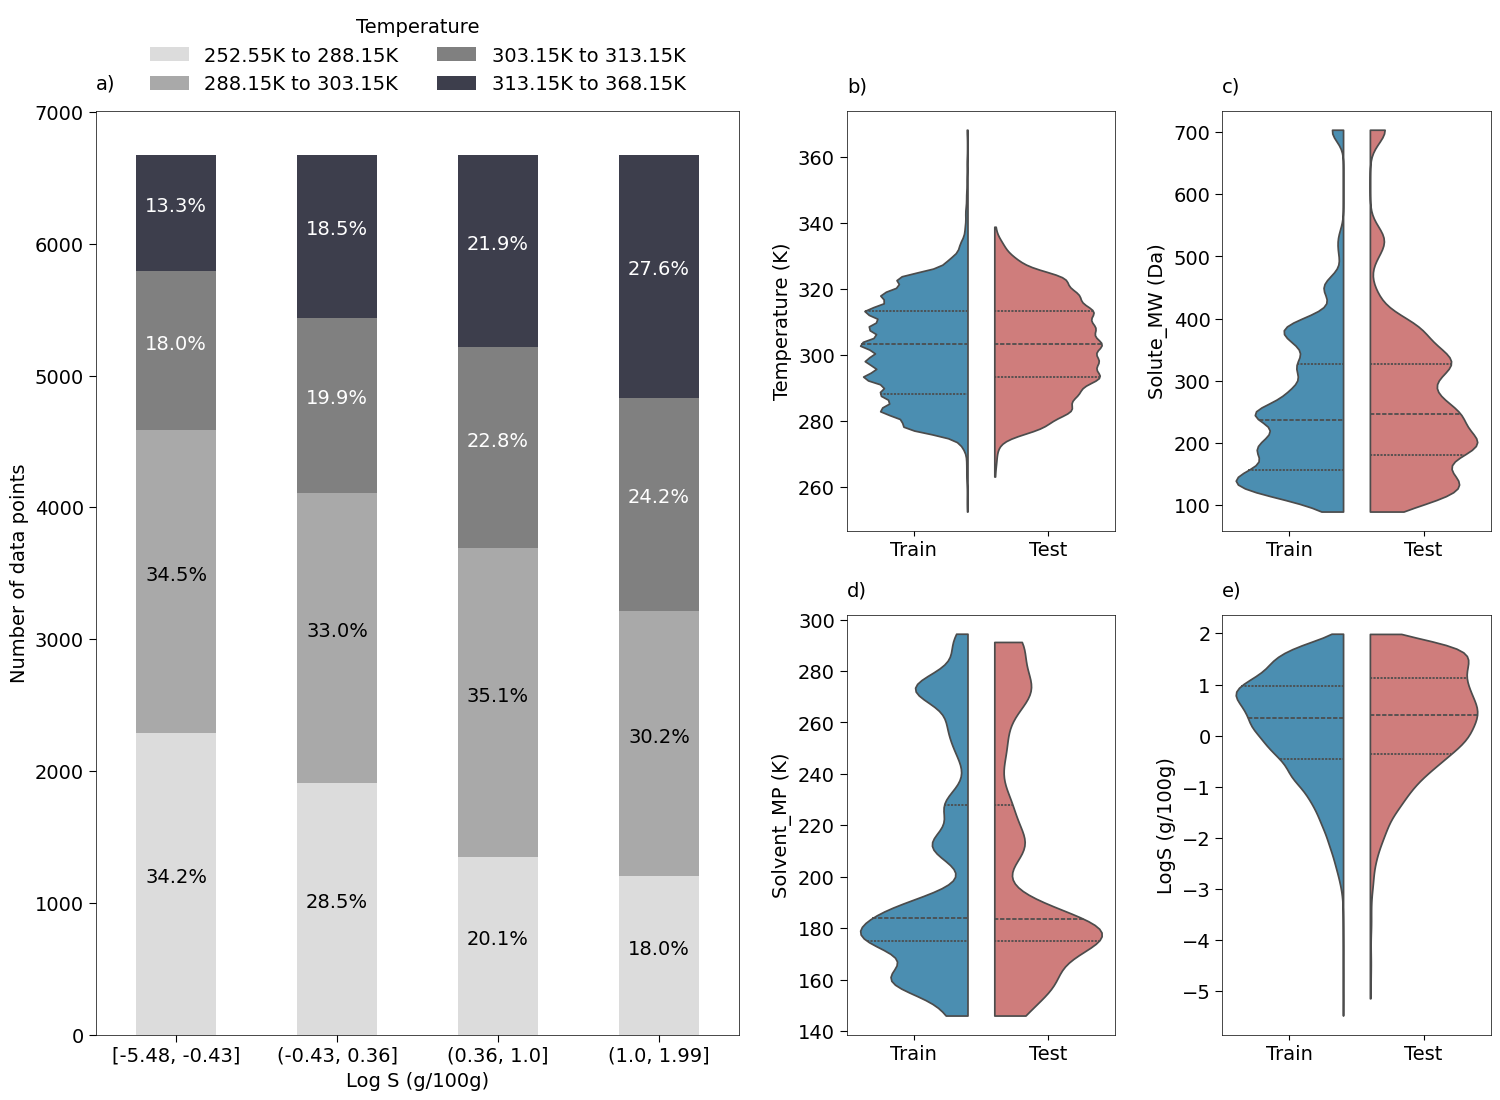

In [52]:
fig = plt.figure(figsize=(18, 12))

grid = plt.GridSpec(2, 4, wspace=0.4, hspace=0.2)


ax1 = fig.add_subplot(grid[0:2, 0:2])
plot_stacked_bar_chart('a)',ax1, updated_literature, fontsize = 14)


ax2 = fig.add_subplot(grid[0, 2])
plot_violin('b)',ax2, updated_literature, ['Temperature (K)'], 'Temperature (K)')


ax3 = fig.add_subplot(grid[0, 3])
plot_violin('c)',ax3, updated_literature, ['Drug_ExactMolWt'], 'Solute_MW (Da)')


ax4 = fig.add_subplot(grid[1, 2])
plot_violin('d)',ax4, updated_literature, ['Solvent_1_Collected_Melting_temp (K)','Solvent_2_Collected_Melting_temp (K)'], 'Solvent_MP (K)')


ax5 = fig.add_subplot(grid[1, 3])
plot_violin('e)',ax5, updated_literature, ['LogS'], 'LogS (g/100g)')


fig.patch.set(facecolor='none')


fig.canvas.print_figure('Figure_2_Dataset_overview.png', dpi=600)


plt.show()


In [53]:
updated_literature = updated_literature.rename(columns={
    'Solvent_1_mol_fraction': 'Solvent_mol_fraction',
    'Solvent_1_weight_fraction': 'Solvent_mass_fraction'
})

In [54]:
updated_lab = updated_lab.rename(columns={
    'Solvent_1_mol_fraction': 'Solvent_mol_fraction',
    'Solvent_1_weight_fraction': 'Solvent_mass_fraction'
})

In [55]:
all_feat_df = pd.concat([updated_literature, updated_lab], ignore_index=True)
all_feat_df.shape


(26730, 1205)

In [56]:
all_feat_df

,Web of Science Index,Drug,Solvent_1,Solvent_mass_fraction,Solvent_mol_fraction,Solvent_2,Temperature (K),Solubility (mol/mol),DOI,Drug_Collected_Melting_temp (K),...,Solvent_2_Eccentricity,Solvent_2_Asphericity,Solvent_2_SpherocityIndex,Solvent_2_PBF,Solubility (g/100g),LogS,Class,Drug-solvent system,Solvent system,Type
0,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,0.925052,0.940600,4-Methyl-2-pentanone,293.15,0.168100,doi.org/10.1021/acs.jced.2c00228,511.15,...,0.929256,0.281062,0.433681,0.735697,27.381751,1.437461,"(1.0, 1.99]","1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",4-Methyl-2-pentanone/Dimethyl sulfoxide,Train
1,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,0.845707,0.875500,4-Methyl-2-pentanone,293.15,0.158100,doi.org/10.1021/acs.jced.2c00228,511.15,...,0.929256,0.281062,0.433681,0.735697,25.605519,1.408334,"(1.0, 1.99]","1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",4-Methyl-2-pentanone/Dimethyl sulfoxide,Train
2,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,0.761753,0.804000,4-Methyl-2-pentanone,293.15,0.144200,doi.org/10.1021/acs.jced.2c00228,511.15,...,0.929256,0.281062,0.433681,0.735697,23.248532,1.366396,"(1.0, 1.99]","1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",4-Methyl-2-pentanone/Dimethyl sulfoxide,Train
3,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,0.672768,0.725100,4-Methyl-2-pentanone,293.15,0.125800,doi.org/10.1021/acs.jced.2c00228,511.15,...,0.929256,0.281062,0.433681,0.735697,20.212869,1.305628,"(1.0, 1.99]","1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",4-Methyl-2-pentanone/Dimethyl sulfoxide,Train
4,327,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,0.578193,0.637500,4-Methyl-2-pentanone,293.15,0.106600,doi.org/10.1021/acs.jced.2c00228,511.15,...,0.929256,0.281062,0.433681,0.735697,17.035467,1.231354,"(1.0, 1.99]","1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",4-Methyl-2-pentanone/Dimethyl sulfoxide,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26725,Lab,Aspirin,Ethanol,0.500000,0.281185,Water,298.15,0.015803,Lab,409.15,...,0.942922,0.333653,0.000000,0.000000,10.043375,1.001880,None,Aspirin-Ethanol/Water,Ethanol/Water,Lab
26726,Lab,Aspirin,Ethanol,0.800000,0.610093,Water,298.15,0.046089,Lab,409.15,...,0.942922,0.333653,0.000000,0.000000,19.855270,1.297876,None,Aspirin-Ethanol/Water,Ethanol/Water,Lab
26727,Lab,Aspirin,Ethanol,0.200000,0.089083,Water,313.15,0.002981,Lab,409.15,...,0.942922,0.333653,0.000000,0.000000,2.557410,0.407800,None,Aspirin-Ethanol/Water,Ethanol/Water,Lab
26728,Lab,Aspirin,Ethanol,0.500000,0.281185,Water,313.15,0.029540,Lab,409.15,...,0.942922,0.333653,0.000000,0.000000,17.468437,1.242254,None,Aspirin-Ethanol/Water,Ethanol/Water,Lab


In [57]:
all_feat_df[['Drug_ExactMolWt', 'Drug_MolLogP']].describe()

,Drug_ExactMolWt,Drug_MolLogP
count,26730.000000,26730.000000
mean,256.065901,1.760130
std,119.668605,1.938616
min,89.047678,-3.834600
25%,158.043990,0.676000
50%,243.037902,1.683800
75%,326.129824,3.243300
max,704.239307,8.479100


In [58]:
all_feat_df = all_feat_df.drop(['Web of Science Index','Solubility (mol/mol)', 'DOI', 'Solvent system','Drug_Drugs@FDA'], axis = 1)



In [59]:
all_feat_df.to_csv('Raw_dataset_dataset_20240705.csv', index=False)

In [60]:
all_feat_df['Type']

0        Train
1        Train
2        Train
3        Train
4        Train
         ...  
26725      Lab
26726      Lab
26727      Lab
26728      Lab
26729      Lab
Name: Type, Length: 26730, dtype: object